# K-Fold testing of a Conversation workspace.

This example notebook is used to show you how to generate a K-fold test in conversation, and run the cross validation test. 

## Prerequisites 

For this example to work, you will need to install the libraries below or you have not already done so.


In [ ]:
!pip3 install --upgrade watson_developer_cloud
!pip3 install --upgrade numpy
!pip3 install --upgrade pandas
!pip3 install --upgrade scikit-learn
!pip3 install --upgrade matplotlib

The `ctx` object you get from the Conversation service credentials window. For this example you should create a new service for testing, as the test will generate 10 workspaces. 

You have to set the language of your workspaces. This is a 2 digit language identifier. Check the <A HREF="https://console.bluemix.net/docs/services/conversation/lang-support.html#supported-languages">supported languages</A> page for what codes can be used. 

The `number_of_folds` is set to `5` so you can test this with a free conversation service. For production testing, you should set the `number_of_folds` to `10`. 

In [40]:
ctx = {
  "url": "https://gateway.watsonplatform.net/conversation/api",
  "username": "USERNAME",
  "password": "PASSWORD"
}

language = 'en'

number_of_folds = 5

## Initialise setup.

In [41]:
import pandas as pd
import numpy as np
from watson_developer_cloud import ConversationV1
from sklearn.model_selection import KFold

conversation = ConversationV1( username=ctx.get('username'), password=ctx.get('password'), version='2017-05-26')

## Sample questions. 

For this test we are going to use pre-generated questions. Here you would create your code to read an existing workspace, either online or local. 

The questions below are taken from <A HREF="https://github.com/jt-nti/conversation-starter">Conversation Starter</A>. The file is a `"question","intent"` csv format.

In [42]:
import csv
import requests

intents_url = 'https://raw.githubusercontent.com/jt-nti/conversation-starter/master/training/intents.csv'

rows = list(csv.reader(requests.get(intents_url).text.split('\n')))

# Remove last blank example. 
del(rows[-1])

examples = pd.DataFrame(rows, columns=['question','intent'])

## Generate Folds.

What happens next is we randomise the questions, and split them evenly into `number_of_folds` buckets. 

In [43]:
bucket = np.arange(len(examples))
folds = []

kf = KFold(n_splits=number_of_folds, shuffle=True)
for train_index, test_index in kf.split(bucket):
    train, test = bucket[train_index], bucket[test_index]
    fold = { 
        'test': test,
        'train': train
    }
    folds.append(fold)

## Create intents for fold.
This method will go through CSV lines and create an `intents[]` object for when the workspace is created.


In [44]:
def createIntents(train_list=None):
    results = []
    for i in train_list:
        row = {}
        question = examples.iloc[i]['question']
        intent = examples.iloc[i]['intent']
        
        if not any(intent in x['intent'] for x in results):
            row = { 'intent': intent, 
                    'examples': [ {'text': question } ] } 
        else:
            row = [d for d in results if d.get('intent') == intent][0]
            results[:] = [d for d in results if d.get('intent') != intent]
            e = {'text': question}
            row['examples'].append(e)
            
        results.append(row)
  
    return results

## Create the workspaces. 
Using each 'train' part of the folds, we will create 10 workspaces, and hold the workspace ID for each. We don't do testing straight away as each workspace needs time to train. 

In [45]:
workspaces = []

dialog_nodes = [
    {
     'dialog_node': 'anything_else',
     'description': 'Required to stop the endless loop error.',
     'conditions': 'anything_else',
     'parent': None, 
     'previous_sibling': None,
     'output': {'text': {'values': ['OK'], 'selection_policy' : 'sequential'}}, 
     'context': None,
     'metadata': None,
     'go_to': None
    }
]

i = 0
for fold in folds:
    intents = createIntents(fold['train'])
    response = conversation.create_workspace(name='Fold {}'.format(i),
                                         description='K-Fold Testing workspace.',
                                         language=language,
                                         intents=intents,
                                         dialog_nodes=dialog_nodes,
                                         metadata={})
    workspaces.append(response['workspace_id'])
    print('Created workspace fold {}: {}'.format(i,response['workspace_id']))
    i = i + 1

Created workspace fold 0: 23876ee0-500b-4c4d-be52-8ffc41757b14
Created workspace fold 1: 941a033d-84d7-4d6c-b592-c03716029260
Created workspace fold 2: 366b9bb1-ebb7-4d1f-a7b9-7410a64ff911
Created workspace fold 3: 777c0144-3ce8-47f2-8c11-551a669ef196
Created workspace fold 4: 7e27f2d1-198f-410c-804c-f38bcec51810


## Check workspace status. 
Before you start running the testing, you want to make sure that they are all ready to understand. 

In [48]:
i = 0
for workspace in workspaces:
    response = conversation.get_workspace(workspace_id=workspace, export=False)
    print('Fold: {}. Workspace: {}.  Status: {}'.format(i,workspace, response['status']))
    i = i + 1

Fold: 0. Workspace: 23876ee0-500b-4c4d-be52-8ffc41757b14.  Status: Available
Fold: 1. Workspace: 941a033d-84d7-4d6c-b592-c03716029260.  Status: Available
Fold: 2. Workspace: 366b9bb1-ebb7-4d1f-a7b9-7410a64ff911.  Status: Available
Fold: 3. Workspace: 777c0144-3ce8-47f2-8c11-551a669ef196.  Status: Available
Fold: 4. Workspace: 7e27f2d1-198f-410c-804c-f38bcec51810.  Status: Available


## Run the test.

**IMPORTANT!** Do not run the next piece until the status is `Available` for all workspaces above. 

Now walk through each workspace and test each fold. Generate a final report, and save test information. 

In [52]:
import json
import time

wsid = 0
col_list = [ 'Question', 'Expected Intent', 'Matched', 'Found@',
            'I1', 'C1', 'I2', 'C2', 'I3', 'C3', 'I4', 'C4', 'I5', 'C5',
            'I6', 'C6', 'I7', 'C7', 'I8', 'C8', 'I9', 'C9', 'I10', 'C10'
           ]

fold_results = []
print('Running Folds')

for fold in folds:
    results = []
    workspace = workspaces[wsid]
    test_set = fold['test']

    print('Fold {}. Questions = {}'.format(wsid, len(test_set)))

    counter = 0
    for t in test_set:
        question = examples.iloc[t]['question']
        expected_intent = examples.iloc[t]['intent']
        
        msg = {'text': question }
        
        if counter % 10 == 0: 
            print('X',end='')
        else:
            print('.',end='')
        counter = counter + 1
        
        try: 
            response = conversation.message(workspace_id=workspace, input=msg, alternate_intents=True)
        except:
            print('E', end='')
            time.sleep(5)
            try:
                response = conversation.message(workspace_id=workspace, input=msg, alternate_intents=True)
            except:
                print('E', end='')
                time.sleep(5)
                response = conversation.message(workspace_id=workspace, input=msg, alternate_intents=True)
                
        intents = response['intents']
        
        found_at = [i for i,_ in enumerate(intents) if _['intent'] == expected_intent]
        if found_at == []: 
            found_at = ''
        else:
            found_at = found_at[0]

        row = { 
                'Question': question,
                'Expected Intent': expected_intent,
                'Matched': any(expected_intent in x['intent'] for x in intents),
                'Found@': found_at,
              }
        
        i = 1
        for intent in intents:
            row['I{}'.format(i)] = intent['intent']
            row['C{}'.format(i)] = intent['confidence']
            i = i + 1
        
        results.append(row)
    print('')
    
    fold_result = pd.DataFrame(results, columns=col_list)
    fold_result.to_csv('fold{}.csv'.format(wsid))
    wsid = wsid + 1
    
print('')
print('Done')

Running Folds
Fold 0. Questions = 26
X.........X.........X.....
Fold 1. Questions = 25
X.........X.........X....
Fold 2. Questions = 25
X.........X.........X....
Fold 3. Questions = 25
X.........X.........X....
Fold 4. Questions = 25
X.........X.........X....

Done


## Clean up. 
When all done and you want to remove the workspaces in your test service. 

In [ ]:
for workspace in workspaces:
    response = conversation.delete_workspace(workspace_id=workspace)
    print('Deleted: {}'.format(workspace))


---

# Understanding the results you got. 

At this point you will have four csv files called `foldX.csv` (where `X` = `0` to `number_of_folds`). The next step is to load these, and get the average across all folds. 

Fields in the reports:

| Field | Description | 
| :-| :-|
| Question | The question that was used to test with.     |
| Expected Intent | The intent that was expected to be returned. |
| Matched  | This will be `true` if expected intent shows up in the top 10 intents returned. |
| Found@ | This tells you what position it was found at. 0 = Top. | 
| I**x** | Intent found at recall **x** |
| C**x** | Confidence of Intent found at recall **x** |

--- 

First load the reports into memory. For this example, we are only going to bother with the main answer found. For production however, you would also examine the top 5 intents, so as to see why a particular question failed.

In [90]:
reports = [] 
drop_fields = [ 'C2', 'C3','C4','C5','C6','C7','C8','C9','C10',
                'I2','I3','I4','I5','I6','I7','I8','I9','I10',
                'Found@', 'Matched'
              ]

for x in range(number_of_folds):
    df = pd.read_csv('fold{}.csv'.format(x),header=0,index_col=0)
    df.drop(drop_fields, axis=1, inplace=True)
    df = df.rename(columns={'Expected Intent': 'true_value', 'I1': 'predicted_value', 'C1': 'confidence'})
    
    reports.append(df)
    
# example
reports[0].head(10)

Question  true_value predicted_value  confidence
0          adios  cs-goodbye      cs-goodbye    0.701070
1     good night  cs-goodbye      cs-goodbye    0.411922
2      got to go  cs-goodbye      cs-goodbye    0.901277
3            gtg  cs-goodbye      cs-goodbye    0.119673
4     have to go  cs-goodbye      cs-goodbye    0.934752
5    have to run  cs-goodbye      cs-goodbye    0.951673
6  my time is up  cs-goodbye      cs-goodbye    0.704113
7     need to go  cs-goodbye      cs-goodbye    0.924854
8   over and out  cs-goodbye      cs-goodbye    0.742759
9   see you soon  cs-goodbye      cs-goodbye    0.941084

--- 

Now get the overall details of the reports. These are just some sample metrics. 

In [139]:
records = []
for index, report in enumerate(reports):
    tp = report[report['true_value'] == report['predicted_value']]
    fp = report[report['true_value'] != report['predicted_value']]

    record = {
        'Report': 'report {}'.format(index+1),
        'Total': len(report),
        'Correct': len(tp),
        'Incorrect': len(fp),
        'Accuracy': len(tp) / len(report),
        'Avg Postive Confidence': tp['confidence'].mean(),
        'Avg Negative Confidence': fp['confidence'].mean()
    }
    records.append(record)

df = pd.DataFrame(records,
        columns=['Report','Total','Correct','Incorrect','Accuracy','Avg Postive Confidence', 'Avg Negative Confidence']
)

record = [{ 'Report': 'Total/Average',
           'Total': df['Total'].sum(),
           'Correct': df['Correct'].sum(),
           'Incorrect': df['Incorrect'].sum(),
           'Accuracy': df['Accuracy'].mean(),
           'Avg Postive Confidence': df['Avg Postive Confidence'].mean(),
           'Avg Negative Confidence': df['Avg Negative Confidence'].mean()
}]

dft = pd.DataFrame(record,
        columns=['Report','Total','Correct','Incorrect','Accuracy','Avg Postive Confidence', 'Avg Negative Confidence']
)

df = df.append(dft)

df

Report  Total  Correct  Incorrect  Accuracy  Avg Postive Confidence  \
0       report 1     26       23          3  0.884615                0.739708   
1       report 2     25       22          3  0.880000                0.764297   
2       report 3     25       23          2  0.920000                0.784364   
3       report 4     25       19          6  0.760000                0.771111   
4       report 5     25       20          5  0.800000                0.794046   
0  Total/Average    126      107         19  0.848923                0.770705   

   Avg Negative Confidence  
0                 0.530551  
1                 0.244852  
2                 0.598231  
3                 0.473936  
4                 0.418658  
0                 0.453246

In the report above, we have a good results. The accuracy is > 0.7. The accuracy of correct answers is high, while for wrong answers is low (could be a little better).

---

# Building a confusion matrix.

In this example, we will take the combined results and create a confusion matrix. This will allow us to see where one intent may be interfering with another. 

We start by combining the reports.

In [147]:
df = pd.DataFrame([],columns=['Question','true_value','predicted_value','confidence'])

for report in reports:
    df = df.append(report,ignore_index=True)


For the confusion matrix, we need to specify the fields that are going to be scanned. For this demo, we do this by getting the unique list from the records. 

In [161]:
class_names = examples['intent'].unique()

print('\n'.join(class_names))

cs-goodbye
cs-hello
cs-help
cs-no
cs-thankyou
cs-yes


This next piece of code is for creating the confusion matrix, and is taken from <A HREF="http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py">sckit-learn example</A>.

In [174]:
%matplotlib inline
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)

def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

This last piece of code will display the confusion matrix. 

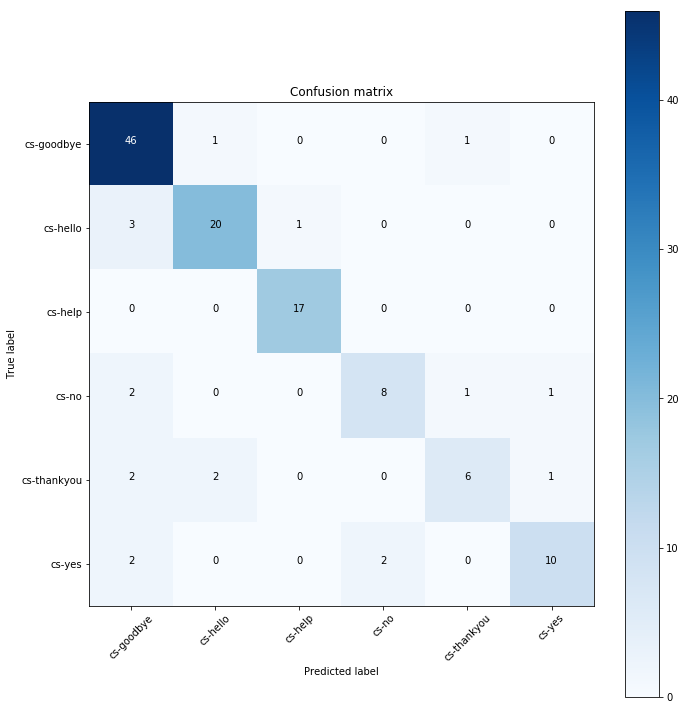

In [175]:
cm_true = df['true_value'].tolist()
cm_predicted = df['predicted_value'].tolist()
cnf_matrix = confusion_matrix(cm_true, cm_predicted,labels=class_names)

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.show()

So you can see that `cs-help` is a well trained intent, while `cs-goodbye` is well trained, it is also pulling in possible weaker clusters. 